# Projet 2
## made by: José Lucas Barretto and Lucas Miguel Celinga Agrizzi

### Question 1)

Import the dataset and sort values based on the date:

In [205]:
import pandas as pd
import numpy as np

df = pd.read_excel('quarterly.xls', sheet_name = 'TB3MS')
df['DATE'] = pd.to_datetime(df.DATE)
df.sort_values('DATE', inplace=True)
df.head(5)

,DATE,FFR,Tbill,Tb1yr,r5,r10,PPINSA,Finished,CPI,CPICORE,M1NSA,M2SA,M2NSA,Unemp,IndProd,RGDP,Potent,Deflator,Curr
0,1960-01-01,3.93,3.87,4.57,4.64,4.49,31.67,33.20,29.40,18.92,140.53,896.1,299.40,5.13,23.93,2845.3,2824.2,18.521,31.830
1,1960-04-01,3.70,2.99,3.87,4.30,4.26,31.73,33.40,29.57,19.00,138.40,903.3,300.03,5.23,23.41,2832.0,2851.2,18.579,31.862
2,1960-07-01,2.94,2.36,3.07,3.67,3.83,31.63,33.43,29.59,19.07,139.60,919.4,305.50,5.53,23.02,2836.6,2878.7,18.648,32.217
3,1960-10-01,2.30,2.31,2.99,3.75,3.89,31.70,33.67,29.78,19.14,142.67,932.8,312.30,6.27,22.47,2800.2,2906.7,18.700,32.624
4,1961-01-01,2.00,2.35,2.87,3.64,3.79,31.80,33.63,29.84,19.17,142.23,948.9,317.10,6.80,22.13,2816.9,2934.8,18.743,32.073


Check for any missing dates/values in the dataset:

In [3]:
quarters = pd.date_range(start = df['DATE'][0], end = df['DATE'][len(df)-1], freq='QS')
missing_quarters = quarters.difference(df['DATE'])
print('missing quarters in the dataset? -', len(missing_quarters)!=0)
print('missing values in the dataset? -', df.isna().any().any())

missing quarters in the dataset? - False
missing values in the dataset? - False


We can see that there are no missing values in the dataset.

### Question 2)

Calculate the quarterly inflation rate in %:

In [4]:
inf = df['CPI'].pct_change().dropna()*100
dates = df['DATE'][1:]

Plot the quarterly inflation rate through time:

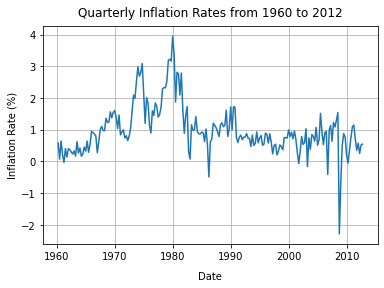

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(dates, inf)
plt.ylabel('Inflation Rate (%)')
plt.xlabel('Date', labelpad=10)
plt.title('Quarterly Inflation Rates from 1960 to 2012', pad=10)
plt.grid()
plt.show()

We can see that the inflation rate has high variations over time, specially in unstable economic periods (such as the year of 2008, for example). We can also note that it is not easy to see a tendency in the data (it is not increasing or decreasing).

### Question 3)

First, we're going to plot the autocorrelogram for *inf*. The idea here is to calculate the correlation between a time series observation and its previous values, which is called the autocorrelation. The autocorrelogram, thus, is just a plot of the autocorrelation by lag. To this end, we can use statsmodels' plot_acf function, which will also plot the region of confidence (values outside the blue region have confidence over 95%).

In our case, we want to see how the inflation rate of one quarter correlates with that of previous quarters.

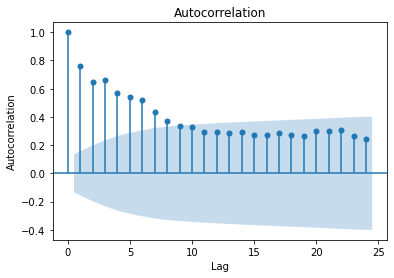

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots()
ax.set_title('Autocorrelogram for Quarterly Inflation Rates', pad=10)
ax.set_ylabel('Autocorrelation')
ax.set_xlabel('Lag')
plot_acf(inf, ax = ax)
plt.show()

We can see in the autocorrelogram above that the inflation rate of a quarter is highly correlated (> 0.5) with those of the 5 previous quarters. Also, since these autocorrelation values are outside the blue region, they have a high statistical confidence (over 95%).

Now, let's plot the partial autocorrelogram. The idea behind the partial autocorrelogram of a time series to obtain the conditional correlation between the observation at time t and the observation at time t-h (lag h), given that we observed what we observed in all timesteps between t and h. Therefore, the partial autocorrelation aims to remove the effects of the observations between the current observation and the observation at lag h, which also means that it removes indirect correlations that are included in the autocorrelogram.

Due to this property, for an AR model of order k, the partial autocorrelations are 0 for every lag beyond k. We can use this information to estimate the order of an AR model by counting the number of lags with non-zero partial autocorrelation.

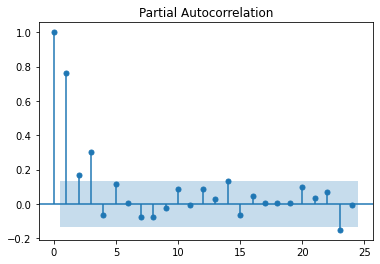

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(inf)
plt.show()

From the partial autocorrelogram above, we can see that the partial autocorrelation is statistically significant for lags up to 3 (values outside the blue region, which means confidence over 95%) and that it oscillates around 0, which could suggest an AR model of order k=3 to predict the inflation.

### Question 4)

In time series analysis, **stationarity** means that the joint distribution for random variables at times $(Y_{s+1}, Y_{s+2}, ..., Y_{s+T})$ does not depend on $s$. This means that the distribution of the processe's variables does not vary over time. 

On the other hand, **ergodicity** means that the process does not depend on initial conditions, and that we can deduce statistical properties given sufficient random samples of a process.

If both of these conditions are satisfied, and the mean of variables is not infinite, then the temporal mean is equal to the spatial mean.

$$
E(Y_t) = \frac{1}{T} \sum_{t=1}^{T}Y_t \rightarrow \mu
$$

A **spurious regression** is a problem that happens when a regression shows evidence of a non-existing relationship between two variables. This means that the regression coefficient estimate should be zero (because the two variables are uncorrelated), but the regression returns a statistically significant value that is not zero, but has a high $R^2$ value (generalizes very badly). This can happen, if the time series are random walks, which are non-stationary.

### Question 5)

We want to find the value of p that produces the best AR(p) model for the inflation values. We can do this by testing multiple AR(p) models, with varying values for p, and choosing the value that generates the model with lowest AIC value (which measures model quality while taking complexity into account).

In [8]:
import warnings
from statsmodels.tsa.api import AutoReg

# disable warnings for improved visualization of the results
warnings.filterwarnings('ignore')

# test AR(p) models for different values of p
max_p = 7
results = {}
for lag in range(1, max_p):
    # fit the model
    model = AutoReg(inf, lags=lag).fit()
    
    # save results into a dict
    results[lag] = [model.aic, model.bic]
    print('lags:', lag, '- AIC:', model.aic, '- BIC:', model.bic)

# choose the value of p that generates the AR(p) with lowest AIC values
best_lag = min(results, key = lambda k: results[k][0])
print('lag value with lowest AIC:', best_lag)

# build the model with the obtained value for p
model = AutoReg(inf, lags=best_lag)
model_results = model.fit()
print('\n', model_results.summary())

lags: 1 - AIC: -1.3546907748283459 - BIC: -1.3068749529609534
lags: 2 - AIC: -1.3771598479087657 - BIC: -1.3131917282539367
lags: 3 - AIC: -1.457867594311414 - BIC: -1.3776383135493633
lags: 4 - AIC: -1.451937606983782 - BIC: -1.3553370622514525
lags: 5 - AIC: -1.4533109129135484 - BIC: -1.3402277421294364
lags: 6 - AIC: -1.4384124181490383 - BIC: -1.308733979938759
lag value with lowest AIC: 3

                             AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                  211
Model:                     AutoReg(3)   Log Likelihood                -138.521
Method:               Conditional MLE   S.D. of innovations              0.471
Date:                Sat, 21 Nov 2020   AIC                             -1.458
Time:                        13:17:33   BIC                             -1.378
Sample:                             3   HQIC                            -1.425
                                  211          

### Question 6)

The Phillips Curve model is a simple static time-series model that expresses the unemployment rate at a time $t$ in function of the inflation rate at the same time $t$: 

*unemployment rate*$_t$ = $\beta_0 + \beta_1$*inflation*$_t + u_t$

We can build this using the OLS model from the statsmodels package.

In [18]:
from statsmodels.api import OLS

unemp = df['Unemp'][1:]
y = unemp
const = np.ones(y.shape)
X = np.column_stack((const, inf))

phillips = OLS(y, X)
phillips_results = phillips.fit()
print(phillips_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Unemp   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.01214
Date:                Sat, 21 Nov 2020   Prob (F-statistic):              0.912
Time:                        13:18:26   Log-Likelihood:                -400.28
No. Observations:                 211   AIC:                             804.6
Df Residuals:                     209   BIC:                             811.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0708      0.181     33.576      0.0

We can plot the OLS predictions to see how it fit the data we used.

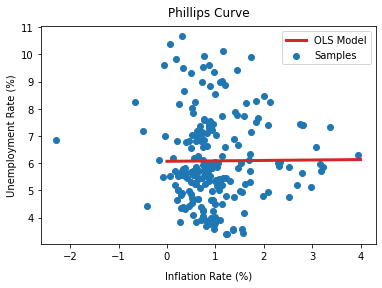

In [55]:
# generate model predictions on a linspace of inflation values
inf_samples = np.linspace(0,4,100)
const = np.ones(inf_samples.size)
X_samples = np.column_stack((const, inf_samples))

pred = phillips_results.predict(X_samples)

# plot the original samples and the OLS predictions
plt.figure()
plt.plot(inf_samples, pred, c='tab:red', lw=3, label='OLS Model')
plt.scatter(inf, y, label='Samples')
plt.legend()
plt.title('Phillips Curve', pad=10)
plt.xlabel('Inflation Rate (%)', labelpad=10)
plt.ylabel('Unemployment Rate (%)')
plt.show()

### Question 7)

First, let's visualize the errors (or residuals) of the OLS model.

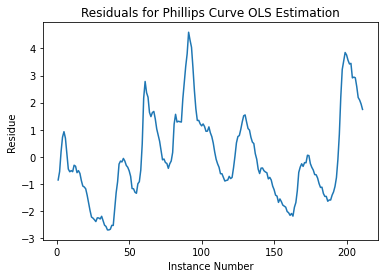

In [11]:
# obtain residuals from OLS model
residuals = phillips_results.resid

# plot residuals
plt.figure()
plt.title('Residuals for Phillips Curve OLS Estimation')
plt.xlabel('Instance Number')
plt.ylabel('Residue')
plt.plot(residuals)
plt.show()

Now, we want to verify if errors are autocorrelated. To this end, we can test the hypothesis $H_0$ that the errors are serially uncorrelated. For an AR(1) model, $u_t = \rho u_{t-1} + e_t$, this hypothesis can be translated to:

$$
H_0: \rho = 0
$$

Therefore, we can fit an AR(1) model to the residuals of the Phillips Curve OLS Estimator and check the t-value for $\rho$ to test the null hypothesis.

In [12]:
residuals_ar = AutoReg(residuals, lags=1)
residuals_ar_results = residuals_ar.fit()
print(residuals_ar_results.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  211
Model:                     AutoReg(1)   Log Likelihood                 -70.272
Method:               Conditional MLE   S.D. of innovations              0.338
Date:                Sat, 21 Nov 2020   AIC                             -2.140
Time:                        13:17:34   BIC                             -2.092
Sample:                             1   HQIC                            -2.121
                                  211                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0122      0.023      0.524      0.601      -0.034       0.058
y.L1           0.9800      0.014     67.714      0.000       0.952       1.008
                                    Roots           

We can see that the p-value for the coefficient $\rho$ (appears as y.L1 in the model's summary) is approximately 0. Therefore, we reject the null hypothesis that the errors are serially uncorrelated at 5%, and conclude that the errors are autocorrelated.

###  Question 8)

To correct the issue of error autocorrelation, we can build the following regression model for the Phillips Curve:

$$
\tilde{y_t} - \rho y_{t-1} = \beta_0(1-\rho) + \beta_1(\tilde{x_t}) + e_t
$$

Where $\tilde{y_t} = y_t - \rho y_{t-1}$ and $\tilde{x_t} = x_t - \rho x_{t-1}$.

In [42]:
# obtain the rho value for the residuals of the AR(1) model
rho = residuals_ar_results.params[1]

# create y_hat variable
y = unemp.to_numpy()
y_t1 = y[1:]
y_t0 = y[:-1]

y_hat = y_t1 - rho*y_t0

# create x_hat variable
x = inf.to_numpy()
x_t1 = x[1:]
x_t0 = x[:-1]

x_hat = x_t1 - rho*x_t0
const_hat = np.ones(x_hat.shape) - rho
X_hat = np.column_stack((const_hat, x_hat))

# regress y_hat on x_hat
phillips_correction = OLS(y_hat, X_hat)
phillips_correction_results = phillips_correction.fit()
print(phillips_correction_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     5.203
Date:                Sat, 21 Nov 2020   Prob (F-statistic):             0.0236
Time:                        16:31:57   Log-Likelihood:                -66.797
No. Observations:                 210   AIC:                             137.6
Df Residuals:                     208   BIC:                             144.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             6.7936      1.152      5.899      0.0

We can see in the plot below that the residual autocorrelation is significantly reduced after we perform this correction in the OLS model:

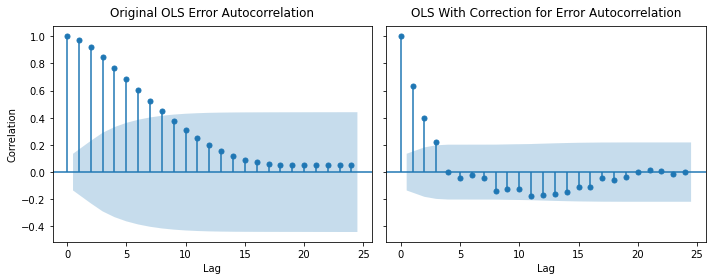

In [204]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,4))
plot_acf(residuals, ax=ax[0])
plot_acf(phillips_correction_results.resid, ax=ax[1])
ax[0].set_title('Original OLS Error Autocorrelation', pad=10)
ax[1].set_title('OLS With Correction for Error Autocorrelation', pad=10)
ax[0].set_ylabel('Correlation')
ax[0].set_xlabel('Lag')
ax[1].set_xlabel('Lag')
plt.tight_layout()
plt.show()

Again, we can plot the OLS predictions to see how it fit the data we used, this time using the estimator with correction for autocorrelated errors.

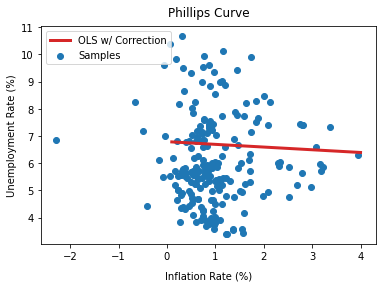

In [43]:
# generate model predictions on a linspace of inflation values
inf_samples = np.linspace(0.1,4,100)
const = np.ones(inf_samples.size)
X_samples = np.column_stack((const, inf_samples))

pred = phillips_correction_results.predict(X_samples)

# plot the original samples and the predictions from the OLS w/ correction for autocorrelated error
plt.figure()
plt.plot(inf_samples, pred, c='tab:red', lw=3, label='OLS w/ Correction')
plt.scatter(inf, y, label='Samples')
plt.legend(loc='upper left')
plt.title('Phillips Curve', pad=10)
plt.xlabel('Inflation Rate (%)', labelpad=10)
plt.ylabel('Unemployment Rate (%)')
plt.show()

### Question 9)

First, let's split the data into two, equal sized, subsamples:

In [44]:
half_len = len(inf)//2

inf1 = inf[:half_len]
unemp1 = unemp[:half_len]

inf2 = inf[half_len+1:]
unemp2 = unemp[half_len+1:]

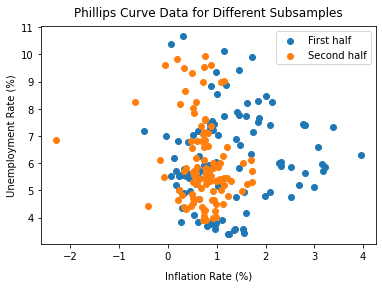

In [45]:
plt.figure()
plt.title('Phillips Curve Data for Different Subsamples', pad=10)
plt.scatter(inf1, unemp1)
plt.scatter(inf2, unemp2)
plt.legend(['First half', 'Second half'])
plt.ylabel('Unemployment Rate (%)')
plt.xlabel('Inflation Rate (%)', labelpad=10)
plt.show()

Now, we want to perform a Chow Test to test the null hypothesis $H_0$: there's no significant improvement in fit by splitting the data and fitting each subsample individually. First, let's obtain the sum of squared residuals (SSR) for the original model:

In [85]:
SSR = phillips_correction_results.ssr
print('SSR for full data model:', round(SSR,4))

SSR for full data model: 23.2287


Now, let's fit individual error corrected models for each subsample of the data:

In [86]:
### Model for the first subsample

# fit the regular phillips curve OLS model
const1 = np.ones(inf1.shape)
X1 = np.column_stack((const1, inf1))

phillips1 = OLS(unemp1, X1)
phillips_results1 = phillips1.fit()

# fit an AR(1) model to the OLS residuals
residuals1 = phillips_results1.resid
residuals1_ar = AutoReg(residuals1, lags=1)
residuals1_ar_results = residuals1_ar.fit()

# obtain the rho value for the residuals of the AR(1) model
rho1 = residuals1_ar_results.params[1]

# create y1_hat variable
y1 = unemp1.to_numpy()
y1_t1 = y1[1:]
y1_t0 = y1[:-1]

y1_hat = y1_t1 - rho1*y1_t0

# create x1_hat variable
x1 = inf1.to_numpy()
x1_t1 = x1[1:]
x1_t0 = x1[:-1]

x1_hat = x1_t1 - rho1*x1_t0
const1_hat = np.ones(x1_hat.shape) - rho1
X1_hat = np.column_stack((const1_hat, x1_hat))

# regress y1_hat on x1_hat
phillips_correction1 = OLS(y1_hat, X1_hat)
phillips_correction1_results = phillips_correction1.fit()
SSR1 = phillips_correction1_results.ssr
print('SSR for subsample 1 model:', round(SSR1,4))

SSR for subsample 1 model: 13.5797


In [87]:
### Model for the second subsample

# fit the regular phillips curve OLS model
const2 = np.ones(inf2.shape)
X2 = np.column_stack((const2, inf2))

phillips2 = OLS(unemp2, X2)
phillips_results2 = phillips2.fit()

# fit an AR(1) model to the OLS residuals
residuals2 = phillips_results2.resid
residuals2_ar = AutoReg(residuals2, lags=1)
residuals2_ar_results = residuals2_ar.fit()

# obtain the rho value for the residuals of the AR(1) model
rho2 = residuals2_ar_results.params[1]

# create y1_hat variable
y2 = unemp2.to_numpy()
y2_t1 = y2[1:]
y2_t0 = y2[:-1]

y2_hat = y2_t1 - rho2*y2_t0

# create x1_hat variable
x2 = inf2.to_numpy()
x2_t1 = x2[1:]
x2_t0 = x2[:-1]

x2_hat = x2_t1 - rho2*x2_t0
const2_hat = np.ones(x2_hat.shape) - rho2
X2_hat = np.column_stack((const2_hat, x2_hat))

# regress y1_hat on x1_hat
phillips_correction2 = OLS(y2_hat, X2_hat)
phillips_correction2_results = phillips_correction2.fit()
SSR2 = phillips_correction2_results.ssr
print('SSR for subsample 2 model:', round(SSR2,4))

SSR for subsample 2 model: 8.7855


Let's plot the fit results for each individual model:

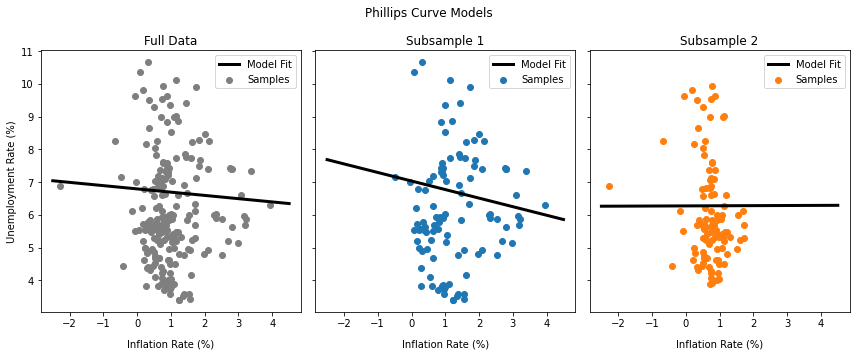

In [81]:
# generate model predictions on a linspace of inflation values
inf_samples = np.linspace(-2.5,4.5,100)
const = np.ones(inf_samples.size)
X_samples = np.column_stack((const, inf_samples))

pred = phillips_correction_results.predict(X_samples)
pred1 = phillips_correction1_results.predict(X_samples)
pred2 = phillips_correction2_results.predict(X_samples)

# plot the original samples and the predictions from the OLS w/ correction for autocorrelated error
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12,5))

ax[0].plot(inf_samples, pred, c='k', lw=3)
ax[0].scatter(inf, unemp, c='tab:grey')
ax[0].set_xlabel('Inflation Rate (%)', labelpad=10)
ax[0].set_ylabel('Unemployment Rate (%)')
ax[0].set_title('Full Data')
ax[0].legend(['Model Fit', 'Samples'])

ax[1].plot(inf_samples, pred1, c='k', lw=3)
ax[1].scatter(inf1, unemp1, c='tab:blue')
ax[1].set_xlabel('Inflation Rate (%)', labelpad=10)
ax[1].set_title('Subsample 1')
ax[1].legend(['Model Fit', 'Samples'])

ax[2].plot(inf_samples, pred2, c='k', lw=3)
ax[2].scatter(inf2, unemp2, c='tab:orange')
ax[2].set_xlabel('Inflation Rate (%)', labelpad=10)
ax[2].set_title('Subsample 2')
ax[2].legend(['Model Fit', 'Samples'])

fig.suptitle('Phillips Curve Models')
plt.tight_layout()
plt.show()

Now, we can calculate the Chow Test F-statistic, which follows an F-distribution with $k$ and $n-2k$ degrees of freedom. Therefore, we can calculate the critical f-value for this distribution as well as the measured statistic p-value.

In [99]:
from scipy.stats import f

k = 2 # number of explanatory variables
n = len(inf1) + len(inf2) # number of samples

F = ((SSR - SSR1 - SSR2)/k)/((SSR1 + SSR2)/(n - 2*k))
print('Chow test F-value:', round(F,4))

F_critical = f.ppf(0.95, k, n-2*k)
print('critical f-value:', round(F_critical, 4))

p_value = 1 - f.cdf(F, k, n-2*k)
print('p-value:', round(p_value, 4))

Chow test F-value: 3.9768
critical f-value: 3.0397
p-value: 0.0202


We can see that the p-value is below 5%, and, therefore, we reject the null hypothesis that there's no improvement in fit by splitting the data and fitting each subsample individually. This indicates that the model for the full data is not stable throughout time.

### Question 10)

To perform the Granger Causality Test, we will test the null hypothesis $H_0$: **inflation does not Granger cause unemployment**. To this end, we're going to fit two OLS models to the unemployment data: one containing the 4 previous lags of unemployment and inflation (unrestricted model), and the other containing only the 4 previous lags of unemployment itself (restricted model).

In [170]:
# 4 previous lags for inflation
inf1 = inf[3:-1]
inf2 = inf[2:-2]
inf3 = inf[1:-3]
inf4 = inf[:-4]

# 4 previous lags for unemployment
unemp1 = unemp[3:-1]
unemp2 = unemp[2:-2]
unemp3 = unemp[1:-3]
unemp4 = unemp[:-4]

const = np.ones(inf1.size)

# unrestricted OLS input
X_u = np.column_stack((const, unemp1, unemp2, unemp3, unemp4, inf1, inf2, inf3, inf4))

# restricted OLS input
X_r = np.column_stack((const, unemp1, unemp2, unemp3, unemp4))

# target
y = unemp[4:]

# fit unrestricted OLS model
phillips_lagged_u = OLS(y, X_u)
phillips_lagged_u_results = phillips_lagged_u.fit()
print('Unrestricted Model:\n')
print(phillips_lagged_u_results.summary())

# fit restricted OLS model
phillips_lagged_r = OLS(y, X_r)
phillips_lagged_r_results = phillips_lagged_r.fit()
print('\n\n\nRestricted Model:\n')
print(phillips_lagged_r_results.summary())

Unrestricted Model:

                            OLS Regression Results                            
Dep. Variable:                  Unemp   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1145.
Date:                Sun, 22 Nov 2020   Prob (F-statistic):          2.80e-161
Time:                        01:34:41   Log-Likelihood:                 4.6497
No. Observations:                 207   AIC:                             8.701
Df Residuals:                     198   BIC:                             38.70
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1457      0.07

We can see that, in the unrestricted model, the coefficients for the previous 4 lags of inflation (x5 through x8) all pass the t-test (they all have p-values over 0.05). Now, we're going to run an F-test under the hypothesis that **adding the 4 previous lags of inflation to the model does not jointly provide a significantly better fit**:

In [167]:
k_u = X_u.shape[1]
k_r = X_r.shape[1]
n = len(y)

ssr_u = phillips_lagged_u_results.ssr
ssr_r = phillips_lagged_r_results.ssr

F = ((ssr_r - ssr_u)/(k_u - k_r))/((ssr_u)/(n - k_u))

p_value = 1 - f.cdf(F, (k_u - k_r), (n - k_u))

print('F-statistics for Granger Causality Test', round(F, 4))
print('p-value of measured F-statistic:', round(p_value, 4))

F-statistics for Granger Causality Test 3.7967
p-value of measured F-statistic: 0.0054


The p-value indicates that we can reject this hypothesis at the 5% significance level. Therefore, we can conclude that adding the 4 previous lags of inflation to the model, in fact, does provide a significantly better fit. Thus, we satisfy conditions for the Granger Test, rejecting hypothesis $H_0$, and we can conclude that inflation Granger causes unemployment.

### Question 11)

We can plot the OLS coefficient for each distributed lag in the previous model to obtain the estimated lag distribution for Unemployment:

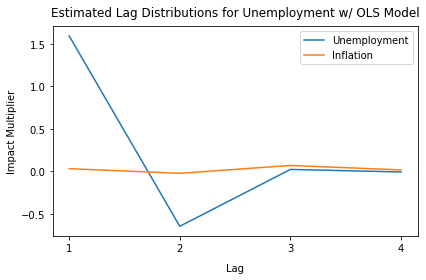

In [192]:
# obtain coefficients
unemp_coefs = phillips_lagged_u_results.params[1:5]
inf_coefs = phillips_lagged_u_results.params[5:]

# x values
lags = np.arange(1,5)

# plot lag distributions
plt.figure()

plt.plot(lags, unemp_coefs)
plt.plot(lags, inf_coefs)

plt.title('Estimated Lag Distributions for Unemployment w/ OLS Model', pad=10)
plt.ylabel('Impact Multiplier')
plt.xlabel('Lag', labelpad=10)
plt.legend(['Unemployment', 'Inflation'])
plt.xticks([1,2,3,4])

plt.tight_layout()
plt.show()

With this plot, we can see the dynamic effect that a temporary increase in each variable (unemployment or inflation) has on unemployment. We can clearly see in the plot above that a temporary increase in the previous value of unemployment is a lot more impactful on unemployment itself than a temporary increase in the previous value of inflation.

We can calculate the inflation rate long run impact on the unemployment rate by adding up all of its coefficients.

In [195]:
LRP = sum(inf_coefs)
print('Previous Inflation Rate long-run impact on Unemployment Rate:', round(LRP,4))

Previous Inflation Rate long-run impact on Unemployment Rate: 0.0928


Therefore, we can estimate a 9.28% increase in the Unemployment due to a permanent one percent increase in the previous Inflation.